In [168]:
# baca data
import pandas as pd
df = pd.read_csv('https://query.data.world/s/tu7xkafdc4jbuzmuh5zxqaeshwj7sv', encoding= 'unicode_escape')
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,CÃ´te D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,CÃ´te D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,CÃ´te D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,CÃ´te D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,CÃ´te D'Ivoire,5.63N,3.23W


In [169]:
# hapus data yang tidak diperlukan
df.drop(['AverageTemperatureUncertainty', 'City','Latitude','Longitude'], axis=1, inplace=True)
df

,dt,AverageTemperature,Country
0,1849-01-01,26.704,CÃ´te D'Ivoire
1,1849-02-01,27.434,CÃ´te D'Ivoire
2,1849-03-01,28.101,CÃ´te D'Ivoire
3,1849-04-01,26.140,CÃ´te D'Ivoire
4,1849-05-01,25.427,CÃ´te D'Ivoire
...,...,...,...
239172,2013-05-01,18.979,China
239173,2013-06-01,23.522,China
239174,2013-07-01,25.251,China
239175,2013-08-01,24.528,China


In [170]:
df['Country'].unique()

array(["CÃ´te D'Ivoire", 'Ethiopia', 'India', 'Syria', 'Egypt', 'Turkey',
       'Iraq', 'Thailand', 'Brazil', 'Germany', 'Colombia',
       'South Africa', 'Morocco', 'China', 'United States', 'Senegal',
       'Tanzania', 'Bangladesh', 'Pakistan', 'Zimbabwe', 'Vietnam',
       'Nigeria', 'Indonesia', 'Saudi Arabia', 'Afghanistan', 'Ukraine',
       'Congo (Democratic Republic Of The)', 'Peru', 'United Kingdom',
       'Angola', 'Spain', 'Philippines', 'Iran', 'Australia', 'Mexico',
       'Somalia', 'Canada', 'Russia', 'Japan', 'Kenya', 'France', 'Burma',
       'Italy', 'Chile', 'Dominican Republic', 'South Korea', 'Singapore',
       'Taiwan', 'Sudan'], dtype=object)

In [171]:
import numpy as np

# ambil data 1 negara
df = df.loc[df['Country'].isin(['Indonesia'])]
df['dt'] = pd.to_datetime((df['dt']).apply(str))
df.AverageTemperature.replace(-99, np.NaN, inplace=True)
df.AverageTemperature.ffill(inplace=True)
df = df.loc[(df.dt >= '1900-01-01') & (df.dt < '2013-09-01'), ['dt', 'AverageTemperature']]
df.set_index('dt', inplace= True)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retu

,AverageTemperature
dt,
1900-01-01,26.060
1900-02-01,26.477
1900-03-01,26.794
1900-04-01,26.753
1900-05-01,26.900


In [172]:
df.isnull().sum()

AverageTemperature    0
dtype: int64

In [173]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df.values, test_size=0.2, shuffle=False)

In [174]:
# Rescale data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scale = scaler.fit_transform(train.reshape(-1, 1))
test_scale = scaler.fit_transform(test.reshape(-1, 1))

In [175]:
split=int((1-0.2)*len(df))

df_train = df.index[:split]
df_test = df.index[split:]

In [176]:
from keras.preprocessing.sequence import TimeseriesGenerator
look_back = 20
train_gen = TimeseriesGenerator(train_scale, train_scale, length=look_back, batch_size=20)     
test_gen = TimeseriesGenerator(test_scale, test_scale, length=look_back, batch_size=1)

In [177]:
import tensorflow as tf
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, input_shape=(look_back, 1)),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(1)
])

In [178]:
MAE = (df['AverageTemperature'].max() - df['AverageTemperature'].min()) * 10/100
print("MAE 10%  = " + str(MAE))

MAE 10%  = 0.49460000000000015


In [179]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.15 and logs.get('val_mae')<0.15):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [180]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

history = model.fit(
    train_gen,
    validation_data = test_gen,
    epochs=10,
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


109/109 [==============================] - 6s 40ms/step - loss: 0.1027 - mae: 0.4325 - val_loss: 0.0838 - val_mae: 0.3740
Epoch 2/10
109/109 [==============================] - 4s 36ms/step - loss: 0.0736 - mae: 0.3602 - val_loss: 0.0620 - val_mae: 0.3114
Epoch 3/10
109/109 [==============================] - 4s 36ms/step - loss: 0.0542 - mae: 0.3035 - val_loss: 0.0474 - val_mae: 0.2633
Epoch 4/10
109/109 [==============================] - 4s 35ms/step - loss: 0.0415 - mae: 0.2586 - val_loss: 0.0375 - val_mae: 0.2263
Epoch 5/10
109/109 [==============================] - 2s 23ms/step - loss: 0.0325 - mae: 0.2234 - val_loss: 0.0306 - val_mae: 0.1983
Epoch 6/10
109/109 [==============================] - 3s 24ms/step - loss: 0.0261 - mae: 0.1950 - val_loss: 0.0257 - val_mae: 0.1779
Epoch 7/10
109/109 [==============================] - 3s 25ms/step - loss: 0.0214 - mae: 0.1725 - val_loss: 0.0221 - val_mae: 0.1629
Epoch 8/10
109/109 [==============================] - 4s 35ms/step - loss: 0.017

In [181]:
# evaluasi performa model yang telah dibuat
import matplotlib.pyplot as plt

def eval_plot(history):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history.history['mae']
  val_acc = history.history['val_mae']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

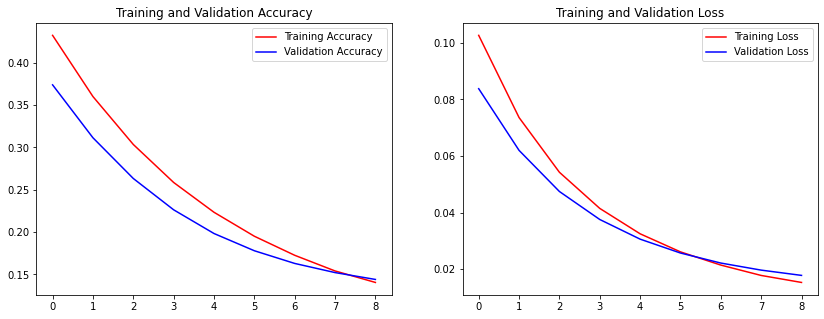

In [182]:
eval_plot(history)